In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

Based on https://www.kaggle.com/zynicide/wine-reviews, the data was scraped from WineEnthusiast during the week of November 22nd, 2017. 

We can also  find the scraper if we want to update the data.

#### Looks like 'winemag-data-130k-v2.csv' has more interesting variables such as title and taster name, I'm going to use it.

Some notes for vaurables
1. description - A few sentences from a sommelier describing the wine's taste, smell, look, feel, etc.
2. designation - The vineyard within the winery where the grapes that made the wine are from
3. title - The title of the wine review (which often contains the vintage, if you are interested in that information)
4. variety - The type of grapes used to make the wine (e.g. "Pinot Noir")

Can find the rest here: 
https://knowledge.domo.com/Training/Self-Service_Training/Onboarding_Resources/Fun_Sample_Datasets

#### References
1. Wine review's Understanding - Pythonic EDA (cool graphs) - https://www.kaggle.com/kabure/wine-review-s-understanding-pythonic-eda 
2. seaborn example - https://www.kaggle.com/residentmario/plotting-with-seaborn 

In [7]:
df = pd.read_csv('winemag-data-130k-v2.csv')
df.shape

(129971, 14)

In [6]:
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


### I wonder the price and points have any correlation, if variety is given.

In [8]:
winery = df['winery'].value_counts()
winery.head()

Wines & Winemakers    222
Testarossa            218
DFJ Vinhos            215
Williams Selyem       211
Louis Latour          199
Name: winery, dtype: int64

In [9]:
len(winery)

16757

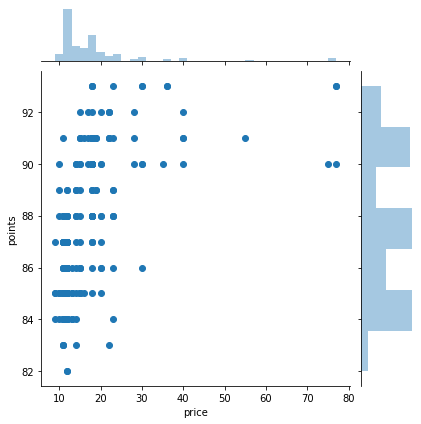

In [41]:
data = df[ df['winery'] == 'Wines & Winemakers']
sns.jointplot(x='price', y='points', data=data)

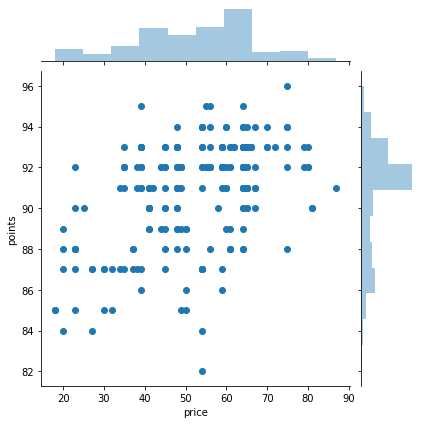

In [42]:
data = df[ df['winery'] == 'Testarossa']
sns.jointplot(x='price', y='points', data=data)

In [44]:
Testarossa = df[ df['winery'] == 'Testarossa']
Testarossa['variety'].value_counts()

Pinot Noir         122
Chardonnay          85
Syrah                8
Red Blend            1
Sauvignon Blanc      1
Meritage             1
Name: variety, dtype: int64

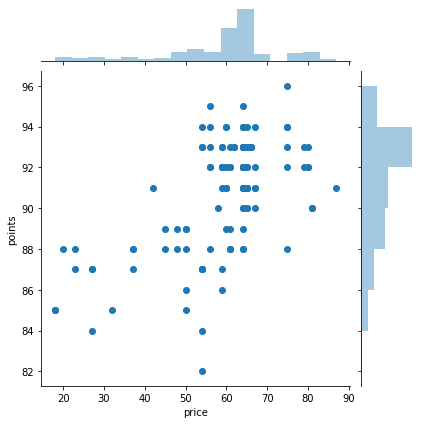

In [45]:
Testarossa_PN = Testarossa[ Testarossa['variety'] == 'Pinot Noir']
sns.jointplot(x='price', y='points', data=Testarossa_PN)

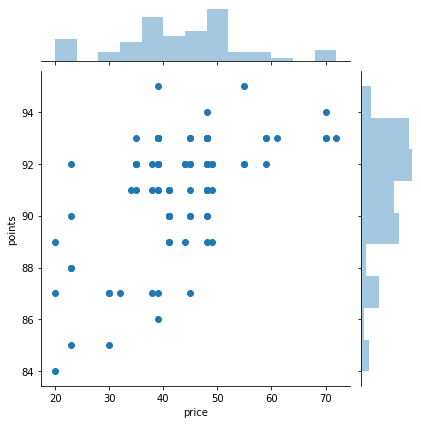

In [46]:
Testarossa_PN = Testarossa[ Testarossa['variety'] == 'Chardonnay']
sns.jointplot(x='price', y='points', data=Testarossa_PN)

### I wonder the price and points have any correlation, if variety is given.

In [10]:
variety = df['variety'].value_counts()
variety.head()

Pinot Noir                  13272
Chardonnay                  11753
Cabernet Sauvignon           9472
Red Blend                    8946
Bordeaux-style Red Blend     6915
Name: variety, dtype: int64

In [11]:
len(variety)

707

In [39]:
Pinot_Noir = df[ df['variety'] == 'Pinot Noir' ]

Text(0, 0.5, 'points')

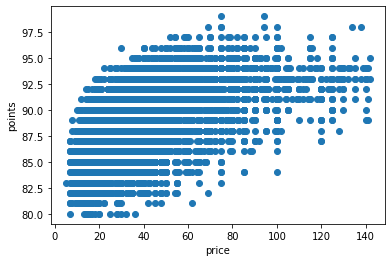

In [22]:
# take away outlier and try again
std = Pinot_Noir['price'].std()
mean = Pinot_Noir['price'].mean()
Pinot_Noir_no_outlier = Pinot_Noir[ (Pinot_Noir['price'] <= mean + 2*std) & (Pinot_Noir['price'] >= mean - 2*std) ]

plt.scatter(Pinot_Noir_no_outlier['price'],Pinot_Noir_no_outlier['points'])
plt.xlabel('price')
plt.ylabel('points')

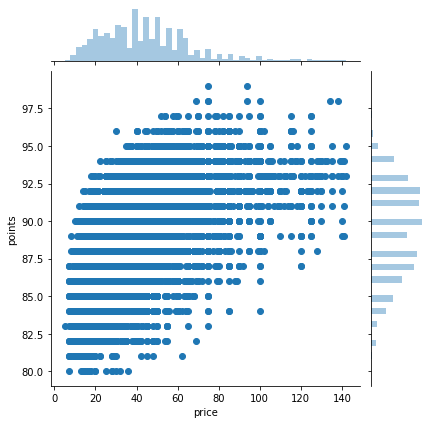

In [40]:
sns.jointplot(x='price', y='points', data=Pinot_Noir_no_outlier)

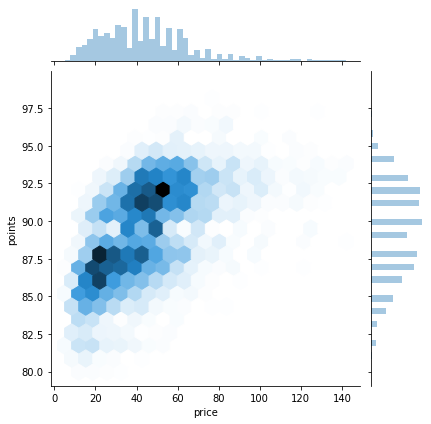

In [29]:
sns.jointplot(x='price', y='points', data=Pinot_Noir_no_outlier, kind='hex', gridsize=20)

It looks like they might have a positvie correlation. But not very clear.

### I wonder the price and points have any correlation, if province is given.

In [12]:
province = df['province'].value_counts()
province.head()

California    36247
Washington     8639
Bordeaux       5941
Tuscany        5897
Oregon         5373
Name: province, dtype: int64

In [13]:
len(province)

425

Text(0, 0.5, 'points')

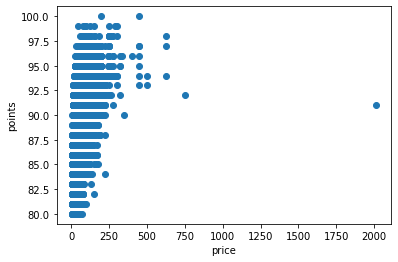

In [21]:
California = df[ df['province'] == 'California' ]
subset = California

plt.scatter(subset['price'],subset['points'])
plt.xlabel('price')
plt.ylabel('points')

In [48]:
California['variety'].value_counts()[:5]

Pinot Noir            6896
Cabernet Sauvignon    5693
Chardonnay            5183
Zinfandel             2639
Syrah                 1870
Name: variety, dtype: int64

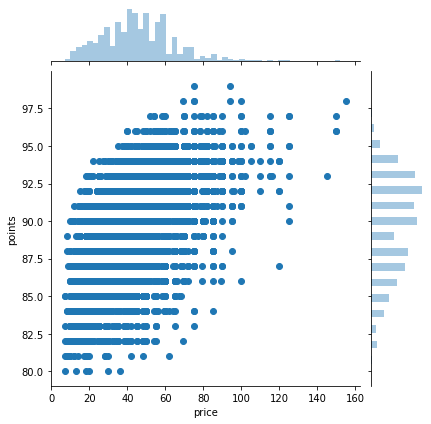

In [49]:
California_NP = California[ California['variety'] == 'Pinot Noir']
sns.jointplot(x='price', y='points', data=California_NP)

Text(0, 0.5, 'points')

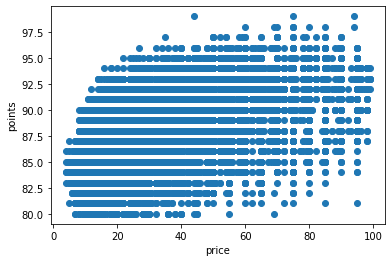

In [23]:
# take away outlier and try again
std = subset['price'].std()
mean = subset['price'].mean()
subset = subset[ (subset['price'] <= mean + 2*std) & (subset['price'] >= mean - 2*std) ]

plt.scatter(subset['price'],subset['points'])
plt.xlabel('price')
plt.ylabel('points')

### Extract vintage from title

In [51]:
len(df['title'].value_counts())

118840

In [61]:
sum(df['title'].isnull())

0

In [106]:
[int(x) for x in re.findall( '20\d\d|19\d\d|18\d\d|17\d\d', "Bella Victorian Vineyard 2007 Kimberly Cabernet Sauvignon (Napa Valley)")]

[2007]

In [120]:
def get_vintage(title):
    output = re.findall('20[0-1]\d|19\d\d', title)
    if len(output) > 0:
        output = [ int(x) for x in output]
        return(max(output))
    else:
        return(np.nan)
df['vintage'] = df['title'].map(get_vintage)

In [121]:
df['vintage'].max()

2017.0

In [122]:
df['vintage'].min()

1904.0

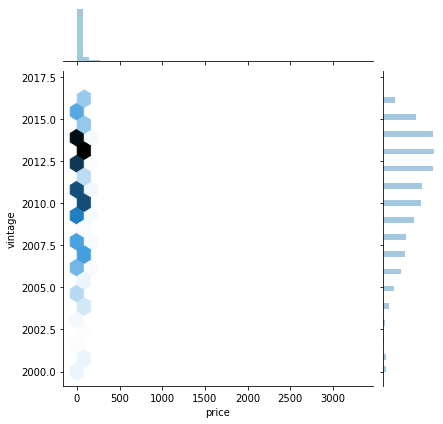

In [126]:
sns.jointplot(x='price', y='vintage', data=df[df['vintage']>=2000], kind='hex', gridsize=20)

Text(0.5, 1.0, 'median price for each year')

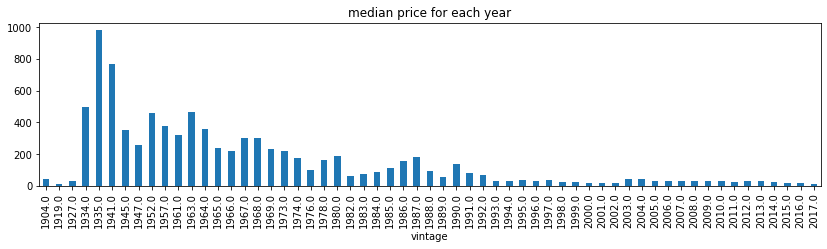

In [139]:
df.groupby(by=['vintage'])['price'].median().plot.bar(figsize = (14,3))
plt.title('median price for each year')

Text(0.5, 1.0, 'max price for each year')

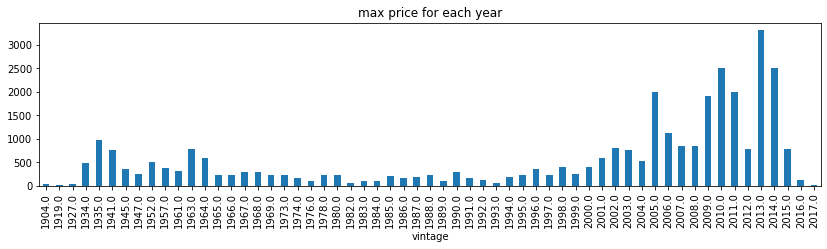

In [138]:
df.groupby(by=['vintage'])['price'].max().plot.bar(figsize = (14,3))
plt.title('max price for each year')